# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0k/60.0k [00:11<00:00, 5.22kFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

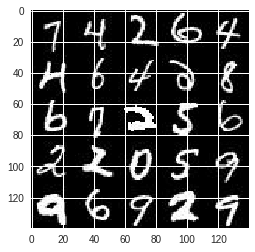

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

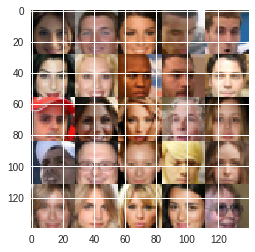

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.13.1
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name="input_real")
    inputs_z = tf.placeholder(tf.float32, [None, z_dim], name="input_z") 
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.1
        
    with tf.variable_scope('discriminator', reuse=reuse):
        
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
                
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
                
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
              
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)                      
        return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Colocations handled automatically by placer.
ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/usr/local/lib/python3.6/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()  File "/usr/local/lib/pyth

### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    alpha = 0.1
             
    with tf.variable_scope('generator', reuse=not is_train):
        
        x1 = tf.layers.dense(z, 7*7*256)
                
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')   
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2) 
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3) 
        
        drop = tf.nn.dropout(x3, keep_prob=0.5)
               
        logits = tf.layers.conv2d_transpose(drop, out_channel_dim, 5, strides=1, padding='same')
            
        return tf.tanh(logits)

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1 
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1 - smooth)))
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
        
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    d_updates = [opt for opt in update_ops if opt.name.startswith('discriminator')]
    g_updates = [opt for opt in update_ops if opt.name.startswith('generator')]

    with tf.control_dependencies(d_updates):
        d_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)

    with tf.control_dependencies(g_updates):
        g_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
            
    return d_opt, g_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [0]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [0]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    print_every=10 
    show_every=100
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_images *= 2
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z})

                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.2541... Generator Loss: 7.4114
Epoch 1/2... Discriminator Loss: 1.3280... Generator Loss: 2.6062
Epoch 1/2... Discriminator Loss: 1.5407... Generator Loss: 2.6239
Epoch 1/2... Discriminator Loss: 2.6888... Generator Loss: 3.1016
Epoch 1/2... Discriminator Loss: 1.9083... Generator Loss: 3.6704
Epoch 1/2... Discriminator Loss: 1.6282... Generator Loss: 1.7287
Epoch 1/2... Discriminator Loss: 1.5689... Generator Loss: 1.6718
Epoch 1/2... Discriminator Loss: 1.8390... Generator Loss: 1.6234
Epoch 1/2... Discriminator Loss: 1.5922... Generator Loss: 1.5388
Epoch 1/2... Discriminator Loss: 1.6136... Generator Loss: 1.6684


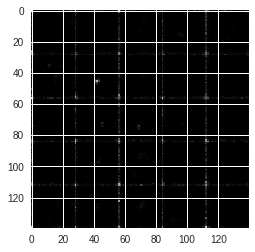

Epoch 1/2... Discriminator Loss: 1.5369... Generator Loss: 1.5306
Epoch 1/2... Discriminator Loss: 1.3050... Generator Loss: 1.1988
Epoch 1/2... Discriminator Loss: 2.5654... Generator Loss: 2.8748
Epoch 1/2... Discriminator Loss: 1.2208... Generator Loss: 0.8931
Epoch 1/2... Discriminator Loss: 1.1854... Generator Loss: 1.4677
Epoch 1/2... Discriminator Loss: 0.4781... Generator Loss: 2.2863
Epoch 1/2... Discriminator Loss: 0.8035... Generator Loss: 1.0725
Epoch 1/2... Discriminator Loss: 0.6594... Generator Loss: 1.7780
Epoch 1/2... Discriminator Loss: 0.8229... Generator Loss: 1.1415
Epoch 1/2... Discriminator Loss: 0.8519... Generator Loss: 1.8000


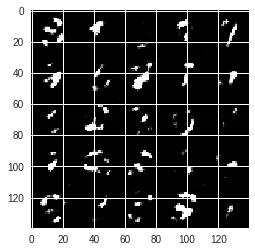

Epoch 1/2... Discriminator Loss: 1.4927... Generator Loss: 2.6499
Epoch 1/2... Discriminator Loss: 1.2381... Generator Loss: 2.3441
Epoch 1/2... Discriminator Loss: 0.9004... Generator Loss: 1.8067
Epoch 1/2... Discriminator Loss: 1.0994... Generator Loss: 1.0642
Epoch 1/2... Discriminator Loss: 0.9988... Generator Loss: 1.0971
Epoch 1/2... Discriminator Loss: 1.3560... Generator Loss: 0.5938
Epoch 1/2... Discriminator Loss: 1.1754... Generator Loss: 1.6352
Epoch 1/2... Discriminator Loss: 0.9490... Generator Loss: 1.3152
Epoch 1/2... Discriminator Loss: 0.9793... Generator Loss: 1.3573
Epoch 1/2... Discriminator Loss: 1.7089... Generator Loss: 0.3871


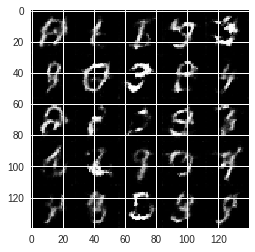

Epoch 1/2... Discriminator Loss: 1.2981... Generator Loss: 2.0884
Epoch 1/2... Discriminator Loss: 1.0890... Generator Loss: 0.8467
Epoch 1/2... Discriminator Loss: 1.2812... Generator Loss: 0.7765
Epoch 1/2... Discriminator Loss: 1.8860... Generator Loss: 1.7702
Epoch 1/2... Discriminator Loss: 1.5273... Generator Loss: 1.8214
Epoch 1/2... Discriminator Loss: 1.0992... Generator Loss: 1.3069
Epoch 1/2... Discriminator Loss: 1.1679... Generator Loss: 0.8556
Epoch 1/2... Discriminator Loss: 1.8459... Generator Loss: 2.0274
Epoch 1/2... Discriminator Loss: 1.1688... Generator Loss: 1.3786
Epoch 1/2... Discriminator Loss: 1.4870... Generator Loss: 0.4905


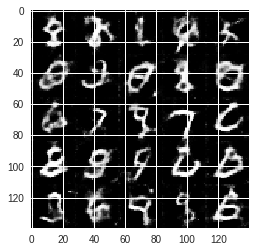

Epoch 1/2... Discriminator Loss: 1.4784... Generator Loss: 0.5122
Epoch 1/2... Discriminator Loss: 1.1945... Generator Loss: 0.8767
Epoch 1/2... Discriminator Loss: 1.1362... Generator Loss: 0.8533
Epoch 1/2... Discriminator Loss: 1.5915... Generator Loss: 0.4416
Epoch 1/2... Discriminator Loss: 1.1236... Generator Loss: 2.2961
Epoch 1/2... Discriminator Loss: 1.5749... Generator Loss: 0.4059
Epoch 1/2... Discriminator Loss: 1.2673... Generator Loss: 1.1884
Epoch 1/2... Discriminator Loss: 1.3097... Generator Loss: 1.3060
Epoch 1/2... Discriminator Loss: 1.4516... Generator Loss: 0.5746
Epoch 1/2... Discriminator Loss: 1.2835... Generator Loss: 1.3314


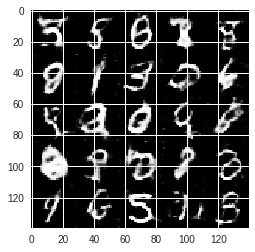

Epoch 1/2... Discriminator Loss: 1.2913... Generator Loss: 1.1392
Epoch 1/2... Discriminator Loss: 2.2004... Generator Loss: 2.5610
Epoch 1/2... Discriminator Loss: 1.2077... Generator Loss: 0.6847
Epoch 1/2... Discriminator Loss: 1.2952... Generator Loss: 0.7258
Epoch 1/2... Discriminator Loss: 2.2082... Generator Loss: 0.2041
Epoch 1/2... Discriminator Loss: 1.1791... Generator Loss: 1.1281
Epoch 1/2... Discriminator Loss: 1.4240... Generator Loss: 1.6330
Epoch 1/2... Discriminator Loss: 1.1957... Generator Loss: 0.8151
Epoch 1/2... Discriminator Loss: 1.1527... Generator Loss: 0.8312
Epoch 1/2... Discriminator Loss: 1.2546... Generator Loss: 1.2259


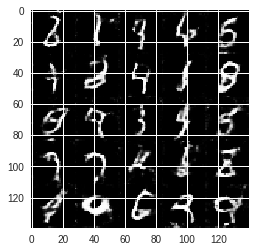

Epoch 1/2... Discriminator Loss: 1.2541... Generator Loss: 1.6884
Epoch 1/2... Discriminator Loss: 2.0376... Generator Loss: 0.2342
Epoch 1/2... Discriminator Loss: 1.2624... Generator Loss: 0.7450
Epoch 1/2... Discriminator Loss: 1.2506... Generator Loss: 0.7952
Epoch 1/2... Discriminator Loss: 1.3820... Generator Loss: 0.5468
Epoch 1/2... Discriminator Loss: 1.1645... Generator Loss: 0.8677
Epoch 1/2... Discriminator Loss: 1.1458... Generator Loss: 1.4336
Epoch 1/2... Discriminator Loss: 1.2988... Generator Loss: 1.4580
Epoch 1/2... Discriminator Loss: 1.1684... Generator Loss: 0.9630
Epoch 1/2... Discriminator Loss: 1.1884... Generator Loss: 0.7979


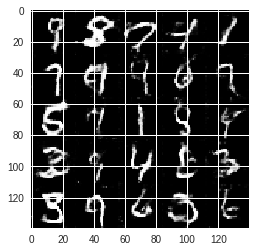

Epoch 1/2... Discriminator Loss: 1.2536... Generator Loss: 1.1307
Epoch 1/2... Discriminator Loss: 1.6773... Generator Loss: 0.4094
Epoch 1/2... Discriminator Loss: 1.1565... Generator Loss: 0.9052
Epoch 1/2... Discriminator Loss: 1.4525... Generator Loss: 0.5106
Epoch 1/2... Discriminator Loss: 1.6890... Generator Loss: 0.4193
Epoch 1/2... Discriminator Loss: 1.1703... Generator Loss: 0.7008
Epoch 1/2... Discriminator Loss: 1.2220... Generator Loss: 1.5464
Epoch 1/2... Discriminator Loss: 1.3388... Generator Loss: 1.6735
Epoch 1/2... Discriminator Loss: 1.2431... Generator Loss: 1.7216
Epoch 1/2... Discriminator Loss: 1.0707... Generator Loss: 1.0783


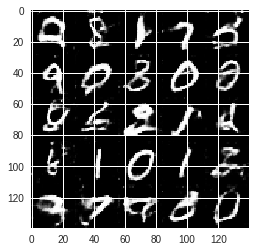

Epoch 1/2... Discriminator Loss: 1.4382... Generator Loss: 1.8897
Epoch 1/2... Discriminator Loss: 1.3520... Generator Loss: 0.5433
Epoch 1/2... Discriminator Loss: 1.4823... Generator Loss: 0.4705
Epoch 1/2... Discriminator Loss: 1.4886... Generator Loss: 0.4534
Epoch 1/2... Discriminator Loss: 1.4038... Generator Loss: 0.5286
Epoch 1/2... Discriminator Loss: 1.1686... Generator Loss: 0.7513
Epoch 1/2... Discriminator Loss: 1.1772... Generator Loss: 0.9676
Epoch 1/2... Discriminator Loss: 1.0524... Generator Loss: 1.0938
Epoch 1/2... Discriminator Loss: 1.1297... Generator Loss: 1.1257
Epoch 1/2... Discriminator Loss: 1.4199... Generator Loss: 0.5807


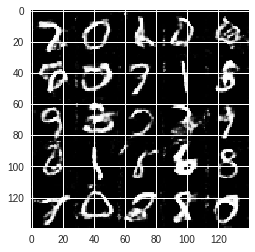

Epoch 1/2... Discriminator Loss: 1.5145... Generator Loss: 2.1381
Epoch 1/2... Discriminator Loss: 1.2301... Generator Loss: 0.6763
Epoch 1/2... Discriminator Loss: 1.1543... Generator Loss: 1.3206
Epoch 2/2... Discriminator Loss: 1.1382... Generator Loss: 0.7115
Epoch 2/2... Discriminator Loss: 1.4852... Generator Loss: 0.5216
Epoch 2/2... Discriminator Loss: 1.4620... Generator Loss: 1.6664
Epoch 2/2... Discriminator Loss: 1.0721... Generator Loss: 0.9405
Epoch 2/2... Discriminator Loss: 1.8037... Generator Loss: 0.3217
Epoch 2/2... Discriminator Loss: 1.4886... Generator Loss: 0.4931
Epoch 2/2... Discriminator Loss: 1.4835... Generator Loss: 0.4520


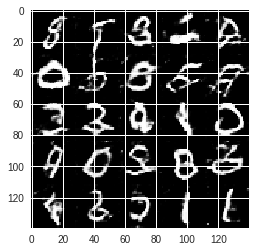

Epoch 2/2... Discriminator Loss: 1.3698... Generator Loss: 0.7997
Epoch 2/2... Discriminator Loss: 1.4009... Generator Loss: 0.5721
Epoch 2/2... Discriminator Loss: 0.9711... Generator Loss: 1.3361
Epoch 2/2... Discriminator Loss: 1.0996... Generator Loss: 1.2179
Epoch 2/2... Discriminator Loss: 1.1775... Generator Loss: 1.4449
Epoch 2/2... Discriminator Loss: 1.1162... Generator Loss: 0.8746
Epoch 2/2... Discriminator Loss: 1.3438... Generator Loss: 0.5629
Epoch 2/2... Discriminator Loss: 1.2947... Generator Loss: 0.6044
Epoch 2/2... Discriminator Loss: 1.0704... Generator Loss: 0.8775
Epoch 2/2... Discriminator Loss: 1.4749... Generator Loss: 0.4738


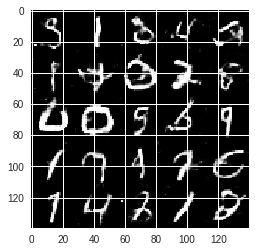

Epoch 2/2... Discriminator Loss: 1.0561... Generator Loss: 1.4681
Epoch 2/2... Discriminator Loss: 1.4739... Generator Loss: 0.4728
Epoch 2/2... Discriminator Loss: 1.5003... Generator Loss: 0.5036
Epoch 2/2... Discriminator Loss: 1.6195... Generator Loss: 0.3851
Epoch 2/2... Discriminator Loss: 1.0457... Generator Loss: 0.8228
Epoch 2/2... Discriminator Loss: 1.7216... Generator Loss: 0.3810
Epoch 2/2... Discriminator Loss: 1.2703... Generator Loss: 0.6742
Epoch 2/2... Discriminator Loss: 0.9849... Generator Loss: 1.0402
Epoch 2/2... Discriminator Loss: 1.3210... Generator Loss: 0.6010
Epoch 2/2... Discriminator Loss: 1.3055... Generator Loss: 0.6011


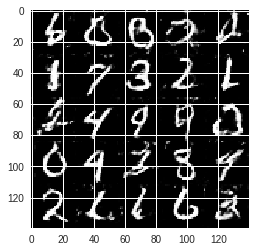

Epoch 2/2... Discriminator Loss: 1.0483... Generator Loss: 1.0007
Epoch 2/2... Discriminator Loss: 1.2331... Generator Loss: 1.5802
Epoch 2/2... Discriminator Loss: 1.3529... Generator Loss: 0.5847
Epoch 2/2... Discriminator Loss: 1.0514... Generator Loss: 0.8029
Epoch 2/2... Discriminator Loss: 1.8971... Generator Loss: 0.3196
Epoch 2/2... Discriminator Loss: 0.9078... Generator Loss: 1.5160
Epoch 2/2... Discriminator Loss: 0.9568... Generator Loss: 1.1638
Epoch 2/2... Discriminator Loss: 1.1526... Generator Loss: 1.2658
Epoch 2/2... Discriminator Loss: 1.2840... Generator Loss: 2.0319
Epoch 2/2... Discriminator Loss: 0.8556... Generator Loss: 1.2903


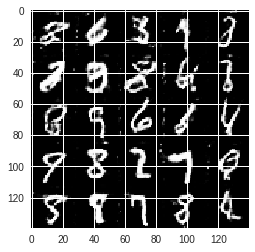

Epoch 2/2... Discriminator Loss: 1.6299... Generator Loss: 0.4126
Epoch 2/2... Discriminator Loss: 0.9465... Generator Loss: 1.8093
Epoch 2/2... Discriminator Loss: 1.2637... Generator Loss: 0.6950
Epoch 2/2... Discriminator Loss: 1.1599... Generator Loss: 1.0297
Epoch 2/2... Discriminator Loss: 1.1886... Generator Loss: 1.6566
Epoch 2/2... Discriminator Loss: 1.0836... Generator Loss: 1.0990
Epoch 2/2... Discriminator Loss: 1.1099... Generator Loss: 1.3680
Epoch 2/2... Discriminator Loss: 1.0755... Generator Loss: 0.8106
Epoch 2/2... Discriminator Loss: 1.0338... Generator Loss: 1.5437
Epoch 2/2... Discriminator Loss: 1.1339... Generator Loss: 1.5740


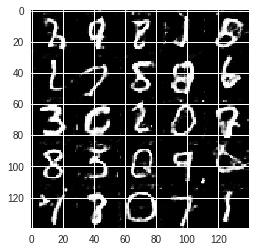

Epoch 2/2... Discriminator Loss: 1.0828... Generator Loss: 0.9882
Epoch 2/2... Discriminator Loss: 0.8901... Generator Loss: 1.0880
Epoch 2/2... Discriminator Loss: 1.2892... Generator Loss: 2.2577
Epoch 2/2... Discriminator Loss: 1.2169... Generator Loss: 0.8710
Epoch 2/2... Discriminator Loss: 1.0186... Generator Loss: 1.1885
Epoch 2/2... Discriminator Loss: 0.9544... Generator Loss: 1.0654
Epoch 2/2... Discriminator Loss: 1.6216... Generator Loss: 0.4456
Epoch 2/2... Discriminator Loss: 1.3532... Generator Loss: 0.6543
Epoch 2/2... Discriminator Loss: 1.2327... Generator Loss: 0.6493
Epoch 2/2... Discriminator Loss: 1.3382... Generator Loss: 0.5903


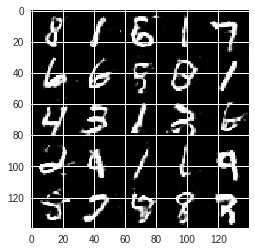

Epoch 2/2... Discriminator Loss: 1.0480... Generator Loss: 0.9010
Epoch 2/2... Discriminator Loss: 1.1584... Generator Loss: 1.2288
Epoch 2/2... Discriminator Loss: 1.1515... Generator Loss: 0.7500
Epoch 2/2... Discriminator Loss: 1.2028... Generator Loss: 1.6517
Epoch 2/2... Discriminator Loss: 0.9884... Generator Loss: 1.4869
Epoch 2/2... Discriminator Loss: 1.1007... Generator Loss: 0.8408
Epoch 2/2... Discriminator Loss: 1.3773... Generator Loss: 0.5415
Epoch 2/2... Discriminator Loss: 0.9255... Generator Loss: 1.0584
Epoch 2/2... Discriminator Loss: 1.6715... Generator Loss: 0.4479
Epoch 2/2... Discriminator Loss: 1.6762... Generator Loss: 0.4645


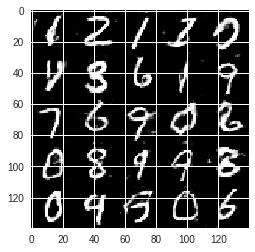

Epoch 2/2... Discriminator Loss: 1.0657... Generator Loss: 0.8417
Epoch 2/2... Discriminator Loss: 0.9020... Generator Loss: 1.1304
Epoch 2/2... Discriminator Loss: 1.7078... Generator Loss: 0.3722
Epoch 2/2... Discriminator Loss: 1.0306... Generator Loss: 0.8893
Epoch 2/2... Discriminator Loss: 1.5559... Generator Loss: 0.4978
Epoch 2/2... Discriminator Loss: 1.4387... Generator Loss: 0.6147
Epoch 2/2... Discriminator Loss: 1.4232... Generator Loss: 0.5453
Epoch 2/2... Discriminator Loss: 1.6051... Generator Loss: 0.4971
Epoch 2/2... Discriminator Loss: 1.0654... Generator Loss: 0.9269
Epoch 2/2... Discriminator Loss: 0.9745... Generator Loss: 1.3591


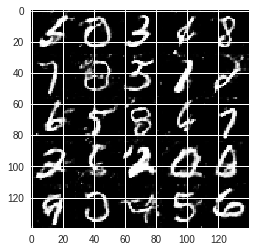

Epoch 2/2... Discriminator Loss: 1.0410... Generator Loss: 1.1253
Epoch 2/2... Discriminator Loss: 1.1938... Generator Loss: 1.3178
Epoch 2/2... Discriminator Loss: 1.2410... Generator Loss: 0.6136
Epoch 2/2... Discriminator Loss: 1.3959... Generator Loss: 0.5188
Epoch 2/2... Discriminator Loss: 1.2181... Generator Loss: 0.7190
Epoch 2/2... Discriminator Loss: 1.0257... Generator Loss: 0.9031
Epoch 2/2... Discriminator Loss: 1.5063... Generator Loss: 0.4983
Epoch 2/2... Discriminator Loss: 0.9630... Generator Loss: 0.9730
Epoch 2/2... Discriminator Loss: 0.8896... Generator Loss: 1.3872
Epoch 2/2... Discriminator Loss: 1.0382... Generator Loss: 1.6199


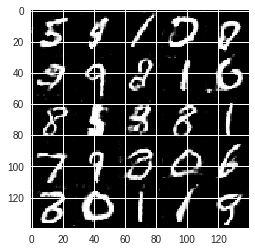

Epoch 2/2... Discriminator Loss: 0.9681... Generator Loss: 1.1274
Epoch 2/2... Discriminator Loss: 1.3582... Generator Loss: 0.5808
Epoch 2/2... Discriminator Loss: 1.1726... Generator Loss: 0.8482
Epoch 2/2... Discriminator Loss: 1.4683... Generator Loss: 0.5294
Epoch 2/2... Discriminator Loss: 1.0685... Generator Loss: 0.8869
Epoch 2/2... Discriminator Loss: 1.0540... Generator Loss: 1.8219
Epoch 2/2... Discriminator Loss: 1.4731... Generator Loss: 0.4799


In [14]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.1083... Generator Loss: 2.2751
Epoch 1/1... Discriminator Loss: 1.6967... Generator Loss: 2.9228
Epoch 1/1... Discriminator Loss: 0.9952... Generator Loss: 1.4019
Epoch 1/1... Discriminator Loss: 0.6448... Generator Loss: 1.9528
Epoch 1/1... Discriminator Loss: 1.4707... Generator Loss: 0.5995
Epoch 1/1... Discriminator Loss: 1.0225... Generator Loss: 0.7807
Epoch 1/1... Discriminator Loss: 0.7752... Generator Loss: 1.5075
Epoch 1/1... Discriminator Loss: 1.7628... Generator Loss: 0.3516
Epoch 1/1... Discriminator Loss: 1.0069... Generator Loss: 0.8574
Epoch 1/1... Discriminator Loss: 1.1126... Generator Loss: 0.8519


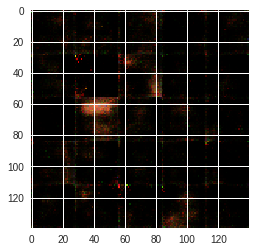

Epoch 1/1... Discriminator Loss: 0.9058... Generator Loss: 1.2186
Epoch 1/1... Discriminator Loss: 1.4116... Generator Loss: 0.6697
Epoch 1/1... Discriminator Loss: 1.2695... Generator Loss: 0.8579
Epoch 1/1... Discriminator Loss: 1.1616... Generator Loss: 1.2793
Epoch 1/1... Discriminator Loss: 1.8583... Generator Loss: 1.3410
Epoch 1/1... Discriminator Loss: 1.2585... Generator Loss: 0.6701
Epoch 1/1... Discriminator Loss: 1.4982... Generator Loss: 0.8391
Epoch 1/1... Discriminator Loss: 1.1289... Generator Loss: 0.7856
Epoch 1/1... Discriminator Loss: 1.7957... Generator Loss: 0.3008
Epoch 1/1... Discriminator Loss: 1.3274... Generator Loss: 0.6126


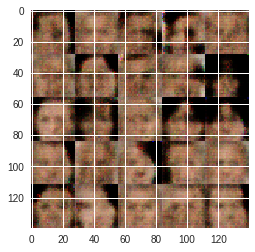

Epoch 1/1... Discriminator Loss: 1.5404... Generator Loss: 1.8292
Epoch 1/1... Discriminator Loss: 4.1417... Generator Loss: 3.2115
Epoch 1/1... Discriminator Loss: 1.4061... Generator Loss: 0.6579
Epoch 1/1... Discriminator Loss: 1.1398... Generator Loss: 0.9836
Epoch 1/1... Discriminator Loss: 1.3767... Generator Loss: 0.9169
Epoch 1/1... Discriminator Loss: 1.9294... Generator Loss: 1.4432
Epoch 1/1... Discriminator Loss: 1.7508... Generator Loss: 1.4041
Epoch 1/1... Discriminator Loss: 1.3499... Generator Loss: 0.8795
Epoch 1/1... Discriminator Loss: 1.4444... Generator Loss: 0.7884
Epoch 1/1... Discriminator Loss: 1.5349... Generator Loss: 0.4707


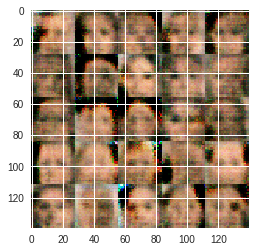

Epoch 1/1... Discriminator Loss: 1.4733... Generator Loss: 0.7374
Epoch 1/1... Discriminator Loss: 1.4786... Generator Loss: 1.0808
Epoch 1/1... Discriminator Loss: 1.4320... Generator Loss: 0.8692
Epoch 1/1... Discriminator Loss: 1.3416... Generator Loss: 0.8256
Epoch 1/1... Discriminator Loss: 1.4920... Generator Loss: 0.5162
Epoch 1/1... Discriminator Loss: 1.4687... Generator Loss: 1.1658
Epoch 1/1... Discriminator Loss: 1.4346... Generator Loss: 1.2352
Epoch 1/1... Discriminator Loss: 1.4421... Generator Loss: 0.6084
Epoch 1/1... Discriminator Loss: 1.3849... Generator Loss: 0.7772
Epoch 1/1... Discriminator Loss: 1.4374... Generator Loss: 0.9665


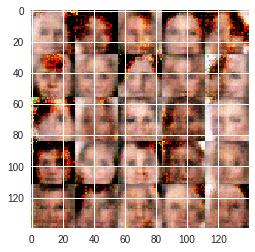

Epoch 1/1... Discriminator Loss: 1.6660... Generator Loss: 1.6238
Epoch 1/1... Discriminator Loss: 1.0836... Generator Loss: 1.0214
Epoch 1/1... Discriminator Loss: 1.2473... Generator Loss: 0.6661
Epoch 1/1... Discriminator Loss: 1.3376... Generator Loss: 1.3311
Epoch 1/1... Discriminator Loss: 1.2020... Generator Loss: 1.0741
Epoch 1/1... Discriminator Loss: 1.2738... Generator Loss: 0.6072
Epoch 1/1... Discriminator Loss: 1.1646... Generator Loss: 1.0768
Epoch 1/1... Discriminator Loss: 1.3897... Generator Loss: 0.7168
Epoch 1/1... Discriminator Loss: 1.1673... Generator Loss: 0.8333
Epoch 1/1... Discriminator Loss: 1.4252... Generator Loss: 1.1668


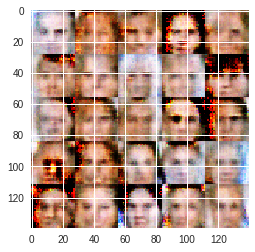

Epoch 1/1... Discriminator Loss: 1.1993... Generator Loss: 0.7086
Epoch 1/1... Discriminator Loss: 1.1085... Generator Loss: 0.8768
Epoch 1/1... Discriminator Loss: 1.3120... Generator Loss: 1.0916
Epoch 1/1... Discriminator Loss: 0.9716... Generator Loss: 2.1566
Epoch 1/1... Discriminator Loss: 0.9462... Generator Loss: 1.0952
Epoch 1/1... Discriminator Loss: 1.0500... Generator Loss: 0.9512
Epoch 1/1... Discriminator Loss: 0.7916... Generator Loss: 1.1232
Epoch 1/1... Discriminator Loss: 0.7985... Generator Loss: 1.0762
Epoch 1/1... Discriminator Loss: 0.9561... Generator Loss: 1.3844
Epoch 1/1... Discriminator Loss: 1.8679... Generator Loss: 0.4329


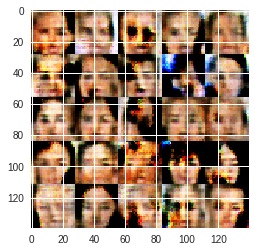

Epoch 1/1... Discriminator Loss: 1.3179... Generator Loss: 0.9520
Epoch 1/1... Discriminator Loss: 1.2985... Generator Loss: 0.8644
Epoch 1/1... Discriminator Loss: 1.1515... Generator Loss: 1.2813
Epoch 1/1... Discriminator Loss: 1.4128... Generator Loss: 0.4695
Epoch 1/1... Discriminator Loss: 1.0449... Generator Loss: 1.3549
Epoch 1/1... Discriminator Loss: 1.6592... Generator Loss: 0.4040
Epoch 1/1... Discriminator Loss: 1.3047... Generator Loss: 0.7852
Epoch 1/1... Discriminator Loss: 1.1146... Generator Loss: 0.8726
Epoch 1/1... Discriminator Loss: 1.0887... Generator Loss: 0.9156
Epoch 1/1... Discriminator Loss: 1.0617... Generator Loss: 0.7805


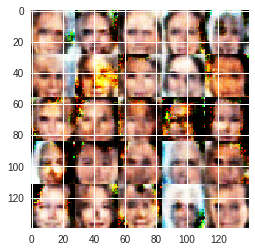

Epoch 1/1... Discriminator Loss: 2.0747... Generator Loss: 1.9191
Epoch 1/1... Discriminator Loss: 1.3752... Generator Loss: 0.6185
Epoch 1/1... Discriminator Loss: 1.1312... Generator Loss: 0.6652
Epoch 1/1... Discriminator Loss: 0.7920... Generator Loss: 1.2128
Epoch 1/1... Discriminator Loss: 1.3264... Generator Loss: 0.8440
Epoch 1/1... Discriminator Loss: 1.2294... Generator Loss: 1.2880
Epoch 1/1... Discriminator Loss: 1.4964... Generator Loss: 1.0952
Epoch 1/1... Discriminator Loss: 1.2192... Generator Loss: 0.6101
Epoch 1/1... Discriminator Loss: 1.2514... Generator Loss: 0.8394
Epoch 1/1... Discriminator Loss: 1.5057... Generator Loss: 0.8618


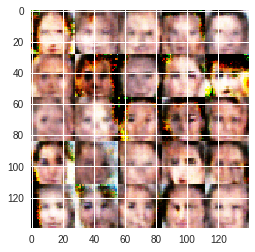

Epoch 1/1... Discriminator Loss: 1.3375... Generator Loss: 0.9166
Epoch 1/1... Discriminator Loss: 1.3517... Generator Loss: 0.9332
Epoch 1/1... Discriminator Loss: 1.3629... Generator Loss: 1.3238
Epoch 1/1... Discriminator Loss: 1.2937... Generator Loss: 1.2063
Epoch 1/1... Discriminator Loss: 1.1552... Generator Loss: 0.9926
Epoch 1/1... Discriminator Loss: 1.3416... Generator Loss: 1.2223
Epoch 1/1... Discriminator Loss: 1.2649... Generator Loss: 0.6513
Epoch 1/1... Discriminator Loss: 1.5364... Generator Loss: 0.4583
Epoch 1/1... Discriminator Loss: 1.1793... Generator Loss: 1.0994
Epoch 1/1... Discriminator Loss: 1.3927... Generator Loss: 0.4341


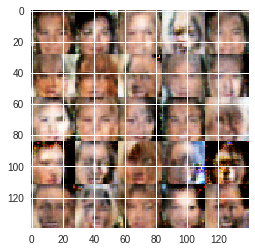

Epoch 1/1... Discriminator Loss: 1.1975... Generator Loss: 0.6968
Epoch 1/1... Discriminator Loss: 1.1480... Generator Loss: 0.7869
Epoch 1/1... Discriminator Loss: 1.3362... Generator Loss: 0.6750
Epoch 1/1... Discriminator Loss: 1.3999... Generator Loss: 0.5880
Epoch 1/1... Discriminator Loss: 1.2380... Generator Loss: 0.7143
Epoch 1/1... Discriminator Loss: 1.2687... Generator Loss: 0.8194
Epoch 1/1... Discriminator Loss: 1.3275... Generator Loss: 0.8558
Epoch 1/1... Discriminator Loss: 1.4024... Generator Loss: 1.0754
Epoch 1/1... Discriminator Loss: 1.2200... Generator Loss: 0.8524
Epoch 1/1... Discriminator Loss: 1.3103... Generator Loss: 0.7762


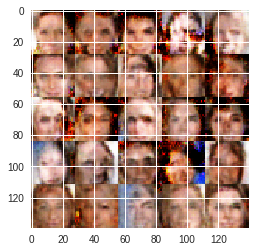

Epoch 1/1... Discriminator Loss: 1.7280... Generator Loss: 1.3656
Epoch 1/1... Discriminator Loss: 1.2636... Generator Loss: 0.7310
Epoch 1/1... Discriminator Loss: 1.3441... Generator Loss: 0.7573
Epoch 1/1... Discriminator Loss: 1.2269... Generator Loss: 1.3750
Epoch 1/1... Discriminator Loss: 1.2657... Generator Loss: 0.6145
Epoch 1/1... Discriminator Loss: 1.2630... Generator Loss: 0.7347
Epoch 1/1... Discriminator Loss: 1.2043... Generator Loss: 0.8365
Epoch 1/1... Discriminator Loss: 1.2819... Generator Loss: 0.7481
Epoch 1/1... Discriminator Loss: 1.2844... Generator Loss: 1.0486
Epoch 1/1... Discriminator Loss: 1.3044... Generator Loss: 0.6247


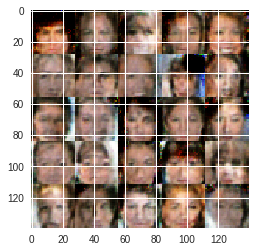

Epoch 1/1... Discriminator Loss: 1.2649... Generator Loss: 0.8654
Epoch 1/1... Discriminator Loss: 1.3784... Generator Loss: 0.8215
Epoch 1/1... Discriminator Loss: 1.1715... Generator Loss: 0.7348
Epoch 1/1... Discriminator Loss: 1.3880... Generator Loss: 0.6141
Epoch 1/1... Discriminator Loss: 1.3231... Generator Loss: 0.7700
Epoch 1/1... Discriminator Loss: 1.3377... Generator Loss: 0.7469
Epoch 1/1... Discriminator Loss: 0.7021... Generator Loss: 1.3521
Epoch 1/1... Discriminator Loss: 1.0908... Generator Loss: 1.9206
Epoch 1/1... Discriminator Loss: 1.2300... Generator Loss: 0.6221
Epoch 1/1... Discriminator Loss: 1.6504... Generator Loss: 1.3646


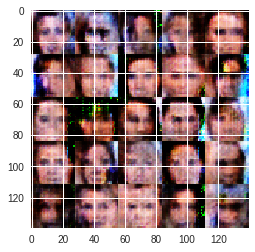

Epoch 1/1... Discriminator Loss: 1.3228... Generator Loss: 0.8871
Epoch 1/1... Discriminator Loss: 1.1440... Generator Loss: 0.7934
Epoch 1/1... Discriminator Loss: 1.3734... Generator Loss: 0.8803
Epoch 1/1... Discriminator Loss: 1.1686... Generator Loss: 0.7721
Epoch 1/1... Discriminator Loss: 1.1905... Generator Loss: 0.8239
Epoch 1/1... Discriminator Loss: 1.4777... Generator Loss: 1.4521
Epoch 1/1... Discriminator Loss: 1.2226... Generator Loss: 1.0143
Epoch 1/1... Discriminator Loss: 1.2479... Generator Loss: 0.8396
Epoch 1/1... Discriminator Loss: 1.3874... Generator Loss: 0.5249
Epoch 1/1... Discriminator Loss: 1.2854... Generator Loss: 1.0119


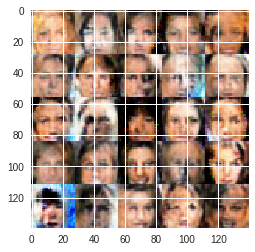

Epoch 1/1... Discriminator Loss: 1.3924... Generator Loss: 0.4870
Epoch 1/1... Discriminator Loss: 1.3873... Generator Loss: 0.6832
Epoch 1/1... Discriminator Loss: 1.2487... Generator Loss: 0.7378
Epoch 1/1... Discriminator Loss: 1.3870... Generator Loss: 0.7121
Epoch 1/1... Discriminator Loss: 1.2899... Generator Loss: 0.8824
Epoch 1/1... Discriminator Loss: 1.2349... Generator Loss: 0.6816
Epoch 1/1... Discriminator Loss: 1.3229... Generator Loss: 0.8014
Epoch 1/1... Discriminator Loss: 1.2811... Generator Loss: 0.9959
Epoch 1/1... Discriminator Loss: 1.3027... Generator Loss: 0.8367
Epoch 1/1... Discriminator Loss: 1.2189... Generator Loss: 0.6356


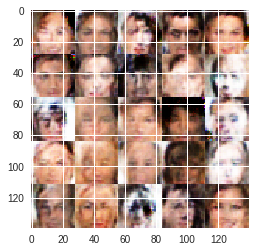

Epoch 1/1... Discriminator Loss: 1.2794... Generator Loss: 0.8654
Epoch 1/1... Discriminator Loss: 1.3409... Generator Loss: 0.9130
Epoch 1/1... Discriminator Loss: 1.3314... Generator Loss: 0.7994
Epoch 1/1... Discriminator Loss: 1.4541... Generator Loss: 1.1968
Epoch 1/1... Discriminator Loss: 1.3883... Generator Loss: 0.7524
Epoch 1/1... Discriminator Loss: 1.2630... Generator Loss: 0.8603
Epoch 1/1... Discriminator Loss: 1.3199... Generator Loss: 0.7464
Epoch 1/1... Discriminator Loss: 1.3665... Generator Loss: 0.6274
Epoch 1/1... Discriminator Loss: 1.3479... Generator Loss: 0.9629
Epoch 1/1... Discriminator Loss: 1.3506... Generator Loss: 0.8639


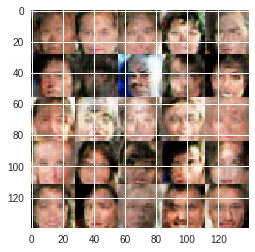

Epoch 1/1... Discriminator Loss: 1.3234... Generator Loss: 0.7066
Epoch 1/1... Discriminator Loss: 1.2738... Generator Loss: 0.9152
Epoch 1/1... Discriminator Loss: 1.1883... Generator Loss: 0.8344
Epoch 1/1... Discriminator Loss: 1.4684... Generator Loss: 0.9340
Epoch 1/1... Discriminator Loss: 1.2659... Generator Loss: 0.8949
Epoch 1/1... Discriminator Loss: 1.3783... Generator Loss: 0.7419
Epoch 1/1... Discriminator Loss: 1.3764... Generator Loss: 0.8290
Epoch 1/1... Discriminator Loss: 1.3160... Generator Loss: 0.8100
Epoch 1/1... Discriminator Loss: 1.1791... Generator Loss: 0.9432
Epoch 1/1... Discriminator Loss: 1.3076... Generator Loss: 0.6920


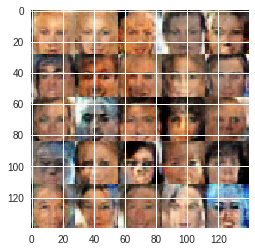

Epoch 1/1... Discriminator Loss: 1.4008... Generator Loss: 0.5002
Epoch 1/1... Discriminator Loss: 1.0351... Generator Loss: 0.8689
Epoch 1/1... Discriminator Loss: 1.0102... Generator Loss: 0.8353
Epoch 1/1... Discriminator Loss: 1.2507... Generator Loss: 0.6517
Epoch 1/1... Discriminator Loss: 1.2755... Generator Loss: 0.8633
Epoch 1/1... Discriminator Loss: 1.1539... Generator Loss: 0.8052
Epoch 1/1... Discriminator Loss: 1.3593... Generator Loss: 0.6278
Epoch 1/1... Discriminator Loss: 1.3518... Generator Loss: 0.8821
Epoch 1/1... Discriminator Loss: 1.2856... Generator Loss: 0.7611
Epoch 1/1... Discriminator Loss: 1.2721... Generator Loss: 0.8341


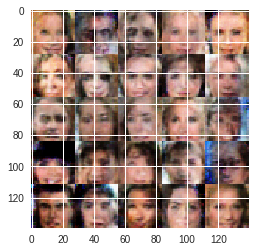

Epoch 1/1... Discriminator Loss: 1.3049... Generator Loss: 0.8189
Epoch 1/1... Discriminator Loss: 1.3289... Generator Loss: 0.7559
Epoch 1/1... Discriminator Loss: 1.2481... Generator Loss: 0.7624
Epoch 1/1... Discriminator Loss: 1.3403... Generator Loss: 0.7376
Epoch 1/1... Discriminator Loss: 1.2398... Generator Loss: 0.8962
Epoch 1/1... Discriminator Loss: 1.3201... Generator Loss: 1.2838
Epoch 1/1... Discriminator Loss: 1.3617... Generator Loss: 0.8822
Epoch 1/1... Discriminator Loss: 1.6442... Generator Loss: 0.3917
Epoch 1/1... Discriminator Loss: 1.3003... Generator Loss: 0.7158
Epoch 1/1... Discriminator Loss: 1.3218... Generator Loss: 0.6825


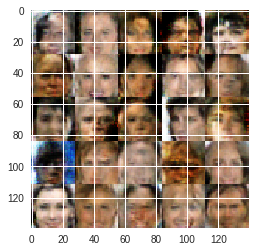

Epoch 1/1... Discriminator Loss: 1.2644... Generator Loss: 1.3364
Epoch 1/1... Discriminator Loss: 1.4306... Generator Loss: 0.6916
Epoch 1/1... Discriminator Loss: 1.2991... Generator Loss: 0.6439
Epoch 1/1... Discriminator Loss: 1.5133... Generator Loss: 0.6854
Epoch 1/1... Discriminator Loss: 1.2020... Generator Loss: 1.0205
Epoch 1/1... Discriminator Loss: 1.3748... Generator Loss: 1.3038
Epoch 1/1... Discriminator Loss: 1.2466... Generator Loss: 0.8532
Epoch 1/1... Discriminator Loss: 1.2992... Generator Loss: 0.8878
Epoch 1/1... Discriminator Loss: 1.3261... Generator Loss: 0.7384
Epoch 1/1... Discriminator Loss: 1.2731... Generator Loss: 0.8257


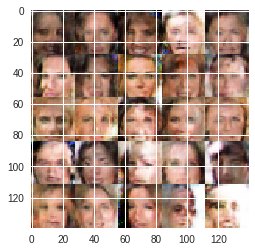

Epoch 1/1... Discriminator Loss: 1.1403... Generator Loss: 0.7556
Epoch 1/1... Discriminator Loss: 1.2440... Generator Loss: 0.5601
Epoch 1/1... Discriminator Loss: 1.3667... Generator Loss: 0.8099
Epoch 1/1... Discriminator Loss: 1.2535... Generator Loss: 0.7921
Epoch 1/1... Discriminator Loss: 1.2802... Generator Loss: 0.9211
Epoch 1/1... Discriminator Loss: 1.1997... Generator Loss: 0.9390
Epoch 1/1... Discriminator Loss: 1.1924... Generator Loss: 1.0695
Epoch 1/1... Discriminator Loss: 1.3623... Generator Loss: 1.2372
Epoch 1/1... Discriminator Loss: 1.1218... Generator Loss: 0.7194
Epoch 1/1... Discriminator Loss: 1.5760... Generator Loss: 1.4970


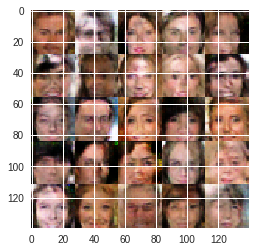

Epoch 1/1... Discriminator Loss: 1.3649... Generator Loss: 0.8782
Epoch 1/1... Discriminator Loss: 1.2684... Generator Loss: 1.0704
Epoch 1/1... Discriminator Loss: 0.9847... Generator Loss: 0.9175
Epoch 1/1... Discriminator Loss: 1.3128... Generator Loss: 0.5998
Epoch 1/1... Discriminator Loss: 1.2378... Generator Loss: 0.9382
Epoch 1/1... Discriminator Loss: 1.1137... Generator Loss: 1.3319
Epoch 1/1... Discriminator Loss: 1.2923... Generator Loss: 0.7870
Epoch 1/1... Discriminator Loss: 1.3091... Generator Loss: 0.9136
Epoch 1/1... Discriminator Loss: 1.2068... Generator Loss: 0.8921
Epoch 1/1... Discriminator Loss: 1.1781... Generator Loss: 1.0150


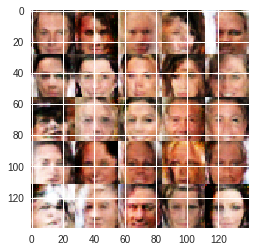

Epoch 1/1... Discriminator Loss: 1.4286... Generator Loss: 0.7738
Epoch 1/1... Discriminator Loss: 1.2881... Generator Loss: 0.8562
Epoch 1/1... Discriminator Loss: 1.0953... Generator Loss: 0.8759
Epoch 1/1... Discriminator Loss: 0.9898... Generator Loss: 0.9491
Epoch 1/1... Discriminator Loss: 1.3789... Generator Loss: 0.7491
Epoch 1/1... Discriminator Loss: 1.1479... Generator Loss: 0.7151
Epoch 1/1... Discriminator Loss: 1.3740... Generator Loss: 0.8549
Epoch 1/1... Discriminator Loss: 1.1751... Generator Loss: 0.6740
Epoch 1/1... Discriminator Loss: 1.2747... Generator Loss: 0.7938
Epoch 1/1... Discriminator Loss: 1.2509... Generator Loss: 0.8937


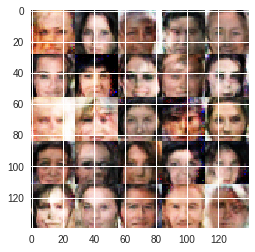

Epoch 1/1... Discriminator Loss: 1.2708... Generator Loss: 0.7144
Epoch 1/1... Discriminator Loss: 1.4394... Generator Loss: 0.5585
Epoch 1/1... Discriminator Loss: 1.3754... Generator Loss: 0.9033
Epoch 1/1... Discriminator Loss: 1.2886... Generator Loss: 0.9276
Epoch 1/1... Discriminator Loss: 1.3594... Generator Loss: 0.9569
Epoch 1/1... Discriminator Loss: 1.3664... Generator Loss: 1.1888
Epoch 1/1... Discriminator Loss: 1.3273... Generator Loss: 1.0598
Epoch 1/1... Discriminator Loss: 1.2264... Generator Loss: 0.8341
Epoch 1/1... Discriminator Loss: 1.1532... Generator Loss: 0.7244
Epoch 1/1... Discriminator Loss: 1.1778... Generator Loss: 1.0323


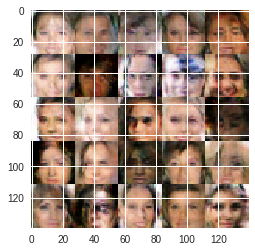

Epoch 1/1... Discriminator Loss: 1.2039... Generator Loss: 0.9572
Epoch 1/1... Discriminator Loss: 1.3180... Generator Loss: 0.7733
Epoch 1/1... Discriminator Loss: 1.2832... Generator Loss: 0.8822
Epoch 1/1... Discriminator Loss: 1.0182... Generator Loss: 1.0415
Epoch 1/1... Discriminator Loss: 1.3227... Generator Loss: 1.1289
Epoch 1/1... Discriminator Loss: 1.2835... Generator Loss: 0.7957
Epoch 1/1... Discriminator Loss: 1.1361... Generator Loss: 0.7729
Epoch 1/1... Discriminator Loss: 1.2744... Generator Loss: 0.8028
Epoch 1/1... Discriminator Loss: 1.3570... Generator Loss: 0.8127
Epoch 1/1... Discriminator Loss: 0.9463... Generator Loss: 1.0437


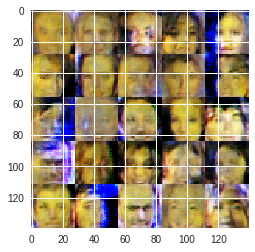

Epoch 1/1... Discriminator Loss: 0.9242... Generator Loss: 1.1387
Epoch 1/1... Discriminator Loss: 1.4952... Generator Loss: 0.7112
Epoch 1/1... Discriminator Loss: 1.6058... Generator Loss: 1.4634
Epoch 1/1... Discriminator Loss: 0.9298... Generator Loss: 0.8553
Epoch 1/1... Discriminator Loss: 1.0196... Generator Loss: 1.3776
Epoch 1/1... Discriminator Loss: 1.6746... Generator Loss: 0.6228
Epoch 1/1... Discriminator Loss: 1.3089... Generator Loss: 0.9475
Epoch 1/1... Discriminator Loss: 1.2516... Generator Loss: 1.3634
Epoch 1/1... Discriminator Loss: 1.3822... Generator Loss: 0.5811
Epoch 1/1... Discriminator Loss: 1.2445... Generator Loss: 0.8966


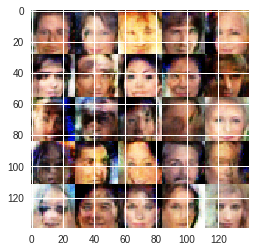

Epoch 1/1... Discriminator Loss: 1.1008... Generator Loss: 1.4461
Epoch 1/1... Discriminator Loss: 1.5324... Generator Loss: 0.6194
Epoch 1/1... Discriminator Loss: 1.2297... Generator Loss: 0.8432
Epoch 1/1... Discriminator Loss: 1.1303... Generator Loss: 0.8439
Epoch 1/1... Discriminator Loss: 1.1761... Generator Loss: 0.7520
Epoch 1/1... Discriminator Loss: 1.2957... Generator Loss: 1.0062
Epoch 1/1... Discriminator Loss: 1.2390... Generator Loss: 0.7517
Epoch 1/1... Discriminator Loss: 1.1662... Generator Loss: 0.8040
Epoch 1/1... Discriminator Loss: 1.2440... Generator Loss: 0.7485
Epoch 1/1... Discriminator Loss: 1.2255... Generator Loss: 1.1037


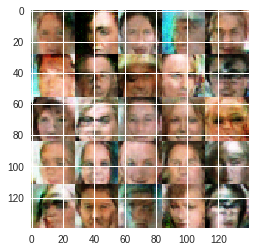

Epoch 1/1... Discriminator Loss: 1.2875... Generator Loss: 0.8704
Epoch 1/1... Discriminator Loss: 1.1903... Generator Loss: 0.9166
Epoch 1/1... Discriminator Loss: 1.2356... Generator Loss: 0.8750
Epoch 1/1... Discriminator Loss: 1.4955... Generator Loss: 1.6547
Epoch 1/1... Discriminator Loss: 1.3562... Generator Loss: 0.8596
Epoch 1/1... Discriminator Loss: 1.0812... Generator Loss: 0.7616
Epoch 1/1... Discriminator Loss: 1.1953... Generator Loss: 0.8496
Epoch 1/1... Discriminator Loss: 1.2017... Generator Loss: 0.9788
Epoch 1/1... Discriminator Loss: 1.2200... Generator Loss: 0.8125
Epoch 1/1... Discriminator Loss: 1.4632... Generator Loss: 0.6249


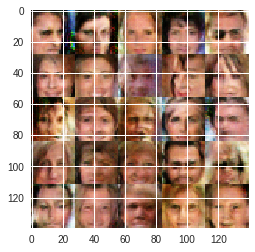

Epoch 1/1... Discriminator Loss: 1.4405... Generator Loss: 0.4958
Epoch 1/1... Discriminator Loss: 1.3062... Generator Loss: 0.9154
Epoch 1/1... Discriminator Loss: 1.2222... Generator Loss: 0.9264
Epoch 1/1... Discriminator Loss: 1.2693... Generator Loss: 0.8506
Epoch 1/1... Discriminator Loss: 1.3191... Generator Loss: 0.7577
Epoch 1/1... Discriminator Loss: 1.1856... Generator Loss: 0.8600
Epoch 1/1... Discriminator Loss: 1.2652... Generator Loss: 0.9077
Epoch 1/1... Discriminator Loss: 1.2018... Generator Loss: 1.0183
Epoch 1/1... Discriminator Loss: 0.9537... Generator Loss: 0.8828
Epoch 1/1... Discriminator Loss: 1.1370... Generator Loss: 0.7086


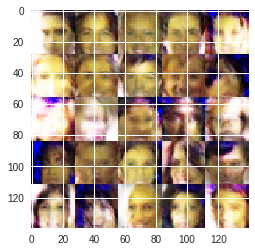

Epoch 1/1... Discriminator Loss: 1.2000... Generator Loss: 0.7223
Epoch 1/1... Discriminator Loss: 1.2036... Generator Loss: 0.8302
Epoch 1/1... Discriminator Loss: 1.1276... Generator Loss: 0.8085
Epoch 1/1... Discriminator Loss: 1.2236... Generator Loss: 0.7969
Epoch 1/1... Discriminator Loss: 1.2269... Generator Loss: 0.8309
Epoch 1/1... Discriminator Loss: 1.1023... Generator Loss: 0.9107
Epoch 1/1... Discriminator Loss: 1.2351... Generator Loss: 0.8414
Epoch 1/1... Discriminator Loss: 1.2677... Generator Loss: 1.0208
Epoch 1/1... Discriminator Loss: 1.2078... Generator Loss: 0.8017
Epoch 1/1... Discriminator Loss: 1.5899... Generator Loss: 0.5434


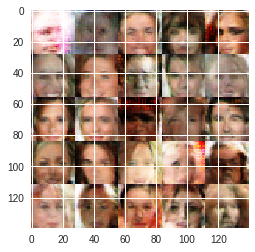

Epoch 1/1... Discriminator Loss: 1.3052... Generator Loss: 0.7385
Epoch 1/1... Discriminator Loss: 1.1943... Generator Loss: 0.7337
Epoch 1/1... Discriminator Loss: 1.2355... Generator Loss: 0.6860
Epoch 1/1... Discriminator Loss: 1.3946... Generator Loss: 0.5324
Epoch 1/1... Discriminator Loss: 1.2178... Generator Loss: 0.9498
Epoch 1/1... Discriminator Loss: 1.2315... Generator Loss: 0.8422
Epoch 1/1... Discriminator Loss: 1.2359... Generator Loss: 0.8046
Epoch 1/1... Discriminator Loss: 1.2358... Generator Loss: 0.8316
Epoch 1/1... Discriminator Loss: 1.2363... Generator Loss: 1.0842
Epoch 1/1... Discriminator Loss: 1.2958... Generator Loss: 0.7768


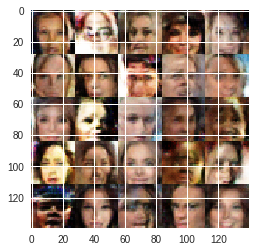

Epoch 1/1... Discriminator Loss: 1.3657... Generator Loss: 0.7168
Epoch 1/1... Discriminator Loss: 1.1257... Generator Loss: 0.6768
Epoch 1/1... Discriminator Loss: 1.2818... Generator Loss: 0.8281
Epoch 1/1... Discriminator Loss: 1.3418... Generator Loss: 1.0450
Epoch 1/1... Discriminator Loss: 1.4102... Generator Loss: 1.4767
Epoch 1/1... Discriminator Loss: 1.2204... Generator Loss: 0.9778
Epoch 1/1... Discriminator Loss: 1.2901... Generator Loss: 0.7158
Epoch 1/1... Discriminator Loss: 1.2074... Generator Loss: 1.0290
Epoch 1/1... Discriminator Loss: 1.2037... Generator Loss: 0.8179
Epoch 1/1... Discriminator Loss: 1.2216... Generator Loss: 0.7974


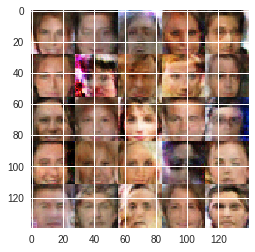

Epoch 1/1... Discriminator Loss: 1.2536... Generator Loss: 0.6724
Epoch 1/1... Discriminator Loss: 1.3652... Generator Loss: 0.6575
Epoch 1/1... Discriminator Loss: 1.2392... Generator Loss: 0.7716
Epoch 1/1... Discriminator Loss: 1.2252... Generator Loss: 0.9018
Epoch 1/1... Discriminator Loss: 1.2635... Generator Loss: 0.8568
Epoch 1/1... Discriminator Loss: 1.2356... Generator Loss: 0.6975


In [15]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.